In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


excel_file_path='/content/Stratify_Project3_Cleaned.xlsx'

# model.load_data_from_excel(file_path) # Call the function with the path
class AdvancedReplenishmentModel:
    def __init__(self):
        self.sales_data = None
        self.inventory_data = None
        self.supplier_data = None
        self.order_delivery_data = None
        self.sku_service_levels = {}

    def load_data_from_excel(self, excel_file_path):
        """
        Load data from Excel file with multiple sheets
        Expected columns:
        - sales: sku, quantity, date, store_id
        - inventory: sku, store_id, current_stock, unit_cost, avg_lead_time, shelf_life_days, service_level, supplier_id
        - suppliers: supplier_id, service_level, delay_rate
        - orders: sku, order_date, delivery_date, supplier_id, quantity
        """
        try:
            # CHANGED: Updated sheet names to match your file structure
            self.sales_data = pd.read_excel(excel_file_path, sheet_name='Sales_data_clean')
            self.inventory_data = pd.read_excel(excel_file_path, sheet_name='inventory_data_clean')
            self.supplier_data = pd.read_excel(excel_file_path, sheet_name='suppliers')
            self.order_delivery_data = pd.read_excel(excel_file_path, sheet_name='orders')

            print(" Data loaded successfully!")
            self._preprocess_data()
            self._extract_service_levels()

        except Exception as e:
            print(f" Error loading data: {e}")
            print("Make sure your Excel file has the correct structure and sheet names.")

    def load_data_from_csv(self, sales_csv, inventory_csv, suppliers_csv, orders_csv):
        """Load data from separate CSV files"""
        try:
            self.sales_data = pd.read_csv(sales_csv)
            self.inventory_data = pd.read_csv(inventory_csv)
            self.supplier_data = pd.read_csv(suppliers_csv)
            self.order_delivery_data = pd.read_csv(orders_csv)

            print(" CSV data loaded successfully!")
            self._preprocess_data()
            self._extract_service_levels()

        except Exception as e:
            print(f" Error loading CSV data: {e}")

    def _preprocess_data(self):
        """Clean and preprocess the loaded data"""
        # Convert date columns
        date_columns = {
            'sales_data': ['date'],
            'order_delivery_data': ['order_date', 'delivery_date']
        }

        for data_name, columns in date_columns.items():
            data = getattr(self, data_name)
            for col in columns:
                if col in data.columns:
                    data[col] = pd.to_datetime(data[col], errors='coerce')

        # Sort by date
        self.sales_data = self.sales_data.sort_values(['sku', 'store_id', 'date'])

        # Remove any rows with missing critical data
        self.sales_data = self.sales_data.dropna(subset=['sku', 'quantity', 'date', 'store_id'])
        self.inventory_data = self.inventory_data.dropna(subset=['sku', 'current_stock', 'unit_cost'])

        print(" Data preprocessing completed!")

    def _extract_service_levels(self):
        """Extract service levels for each SKU from inventory data"""
        for _, row in self.inventory_data.iterrows():
            key = (row['sku'], row['store_id'])
            # Use SKU-specific service level if available, otherwise default to 0.95
            self.sku_service_levels[key] = row.get('service_level', 0.95)

        print(f" Service levels extracted for {len(self.sku_service_levels)} SKU-Store combinations")

    def get_demand_patterns(self, sku, store_id):
        """Analyze detailed demand patterns for better forecasting"""
        sales = self.sales_data[
            (self.sales_data['sku'] == sku) &
            (self.sales_data['store_id'] == store_id)
        ].copy()

        if len(sales) == 0:
            return None

        # Create complete date range
        date_range = pd.date_range(
            start=sales['date'].min(),
            end=sales['date'].max(),
            freq='D'
        )

        # Aggregate daily demand
        daily_demand = sales.groupby('date')['quantity'].sum().reindex(date_range, fill_value=0)

        # Calculate statistics
        demand_stats = {
            'daily_demands': daily_demand.values,
            'mean_daily_demand': daily_demand.mean(),
            'std_daily_demand': daily_demand.std(),
            'cv': daily_demand.std() / daily_demand.mean() if daily_demand.mean() > 0 else 0,
            'max_daily_demand': daily_demand.max(),
            'min_daily_demand': daily_demand.min(),
            'zero_demand_days': (daily_demand == 0).sum(),
            'total_days': len(daily_demand),
            'demand_variability': 'High' if (daily_demand.std() / daily_demand.mean() > 0.5 if daily_demand.mean() > 0 else False) else 'Medium' if (daily_demand.std() / daily_demand.mean() > 0.25 if daily_demand.mean() > 0 else False) else 'Low'
        }

        # Detect seasonality (weekly pattern)
        if len(daily_demand) >= 14:
            weekly_pattern = []
            for day_of_week in range(7):
                day_demands = daily_demand[daily_demand.index.dayofweek == day_of_week]
                weekly_pattern.append(day_demands.mean())

            demand_stats['weekly_pattern'] = weekly_pattern
            demand_stats['has_seasonality'] = max(weekly_pattern) / min(weekly_pattern) > 1.5 if min(weekly_pattern) > 0 else False
        else:
            demand_stats['weekly_pattern'] = None
            demand_stats['has_seasonality'] = False

        return demand_stats

    def advanced_forecast(self, demand_data, periods=21, method='auto'):
        """Advanced forecasting with multiple methods"""
        daily_demands = demand_data['daily_demands']

        if len(daily_demands) < 7:
            # Insufficient data - use simple average
            avg_demand = demand_data['mean_daily_demand']
            return [max(0, np.random.poisson(avg_demand)) for _ in range(periods)]

        forecasts = []

        if method == 'auto':
            # Choose method based on data characteristics
            if demand_data.get('has_seasonality', False) and len(daily_demands) >= 21:
                method = 'holt_winters'
            elif demand_data['cv'] > 0.5:  # High variability
                method = 'croston'
            else:
                method = 'exponential_smoothing'

        if method == 'exponential_smoothing':
            # Double exponential smoothing for trend
            alpha, beta = 0.3, 0.1
            level = daily_demands[0]
            trend = daily_demands[1] - daily_demands[0] if len(daily_demands) > 1 else 0

            for i in range(1, len(daily_demands)):
                prev_level = level
                level = alpha * daily_demands[i] + (1 - alpha) * (level + trend)
                trend = beta * (level - prev_level) + (1 - beta) * trend

            # Generate forecasts
            for i in range(periods):
                forecast = level + trend * (i + 1)
                forecasts.append(max(0, forecast))

        elif method == 'holt_winters':
            # Triple exponential smoothing
            alpha, beta, gamma = 0.3, 0.1, 0.1
            season_length = 7

            if len(daily_demands) >= season_length * 2:
                # Initialize components
                level = np.mean(daily_demands[:season_length])
                trend = (np.mean(daily_demands[season_length:2*season_length]) - level) / season_length
                seasonal = [daily_demands[i] / level for i in range(season_length)]

                # Update components
                for i in range(season_length, len(daily_demands)):
                    prev_level = level
                    level = alpha * (daily_demands[i] / seasonal[i % season_length]) + (1 - alpha) * (level + trend)
                    trend = beta * (level - prev_level) + (1 - beta) * trend
                    seasonal[i % season_length] = gamma * (daily_demands[i] / level) + (1 - gamma) * seasonal[i % season_length]

                # Generate forecasts
                for i in range(periods):
                    forecast = (level + trend * (i + 1)) * seasonal[i % season_length]
                    forecasts.append(max(0, forecast))
            else:
                # Fall back to exponential smoothing
                return self.advanced_forecast(demand_data, periods, 'exponential_smoothing')

        elif method == 'croston':
            # Croston's method for intermittent demand
            non_zero_demands = daily_demands[daily_demands > 0]

            if len(non_zero_demands) > 1:
                avg_demand_size = non_zero_demands.mean()
                intervals = np.diff(np.where(daily_demands > 0)[0])
                avg_interval = np.mean(intervals) if len(intervals) > 0 else 1

                forecast_rate = avg_demand_size / avg_interval
                for _ in range(periods):
                    forecasts.append(max(0, np.random.poisson(forecast_rate)))
            else:
                forecasts = [np.mean(daily_demands)] * periods if len(daily_demands) > 0 else [0] * periods

        return forecasts

    def calculate_optimal_parameters(self, demand_data, inventory_info, supplier_info=None):
        """Calculate optimal inventory parameters with improved accuracy"""

        # Get SKU-specific service level
        service_level = inventory_info.get('service_level', 0.95)

        # Demand parameters
        avg_daily_demand = demand_data['mean_daily_demand']
        std_daily_demand = demand_data['std_daily_demand']
        annual_demand = avg_daily_demand * 365

        # Lead time parameters
        lead_time = inventory_info['avg_lead_time']
        if supplier_info:
            # Adjust lead time based on supplier reliability
            adjusted_lead_time = lead_time * (1 + supplier_info.get('delay_rate', 0))
        else:
            adjusted_lead_time = lead_time

        # Calculate EOQ
        ordering_cost = 50  # Can be made configurable
        holding_cost_rate = 0.25  # Annual rate
        unit_cost = inventory_info['unit_cost']

        eoq = self.calculate_eoq(annual_demand, ordering_cost, holding_cost_rate, unit_cost)

        # Calculate safety stock with lead time demand variability
        lead_time_demand_std = std_daily_demand * np.sqrt(adjusted_lead_time)
        safety_stock = self.calculate_safety_stock(lead_time_demand_std, service_level)

        # Calculate reorder point
        rop = avg_daily_demand * adjusted_lead_time + safety_stock

        # Calculate maximum inventory level for periodic review
        review_period = 7  # Weekly review
        max_inventory = avg_daily_demand * (adjusted_lead_time + review_period) + safety_stock

        return {
            'eoq': max(1, int(eoq)),
            'rop': max(1, int(rop)),
            'safety_stock': max(0, int(safety_stock)),
            'max_inventory': int(max_inventory),
            'service_level': service_level,
            'adjusted_lead_time': adjusted_lead_time,
            'annual_demand': annual_demand,
            'ordering_cost': ordering_cost,
            'holding_cost_rate': holding_cost_rate
        }

    def calculate_eoq(self, annual_demand, ordering_cost, holding_cost_rate, unit_cost):
        """Calculate Economic Order Quantity"""
        if holding_cost_rate <= 0 or unit_cost <= 0 or annual_demand <= 0:
            return annual_demand / 12  # Monthly demand as fallback

        holding_cost = holding_cost_rate * unit_cost
        eoq = np.sqrt((2 * annual_demand * ordering_cost) / holding_cost)
        return max(1, eoq)

    def calculate_safety_stock(self, lead_time_demand_std, service_level):
        """Calculate safety stock using normal distribution"""
        # More precise calculation using scipy
        z_score = stats.norm.ppf(service_level)
        safety_stock = z_score * lead_time_demand_std
        return max(0, safety_stock)

    def comprehensive_sku_analysis(self, sku, store_id=None):
        """Comprehensive analysis for a specific SKU"""
        print(f"\n{'='*80}")
        print(f"🎯 COMPREHENSIVE ANALYSIS FOR SKU: {sku}")
        if store_id:
            print(f"🏪 STORE: {store_id}")
        print(f"{'='*80}")

        # Get inventory information
        if store_id:
            inventory_info = self.inventory_data[
                (self.inventory_data['sku'] == sku) &
                (self.inventory_data['store_id'] == store_id)
            ]
        else:
            inventory_info = self.inventory_data[self.inventory_data['sku'] == sku]

        if len(inventory_info) == 0:
            print(f"No inventory data found for SKU {sku}")
            return None

        inventory_info = inventory_info.iloc[0].to_dict()

        # Get supplier information
        supplier_info = None
        if 'supplier_id' in inventory_info and not pd.isna(inventory_info['supplier_id']):
            supplier_data = self.supplier_data[
                self.supplier_data['supplier_id'] == inventory_info['supplier_id']
            ]
            if len(supplier_data) > 0:
                supplier_info = supplier_data.iloc[0].to_dict()

        # Analyze demand patterns
        demand_data = self.get_demand_patterns(sku, store_id or inventory_info['store_id'])

        if demand_data is None:
            print(f" No sales data found for SKU {sku}")
            return None

        # Calculate optimal parameters
        optimal_params = self.calculate_optimal_parameters(demand_data, inventory_info, supplier_info)

        # Generate forecasts
        forecasts = self.advanced_forecast(demand_data, periods=21, method='auto')

        # Print comprehensive analysis
        print(f"\n INVENTORY STATUS:")
        print(f"    Current Stock: {inventory_info['current_stock']:,}")
        print(f"    Unit Cost: ${inventory_info['unit_cost']:.2f}")
        print(f"    Lead Time: {inventory_info['avg_lead_time']} days")
        print(f"    Shelf Life: {inventory_info.get('shelf_life_days', 'N/A')} days")
        print(f"    SKU Service Level: {optimal_params['service_level']*100:.1f}%")

        if supplier_info:
            print(f"\n SUPPLIER PERFORMANCE:")
            print(f"    Supplier ID: {supplier_info['supplier_id']}")
            print(f"    Service Level: {supplier_info['service_level']*100:.1f}%")
            print(f"    Delay Rate: {supplier_info['delay_rate']*100:.1f}%")
            print(f"    Adjusted Lead Time: {optimal_params['adjusted_lead_time']:.1f} days")

        print(f"\n DEMAND ANALYSIS:")
        print(f"    Average Daily Demand: {demand_data['mean_daily_demand']:.2f}")
        print(f"    Demand Std Dev: {demand_data['std_daily_demand']:.2f}")
        print(f"    Coefficient of Variation: {demand_data['cv']:.2f}")
        print(f"    Demand Variability: {demand_data['demand_variability']}")
        print(f"    Zero Demand Days: {demand_data['zero_demand_days']}/{demand_data['total_days']}")
        print(f"    Seasonality Detected: {'Yes' if demand_data.get('has_seasonality') else 'No'}")
        print(f"    Annual Demand Forecast: {optimal_params['annual_demand']:,.0f}")

        print(f"\n OPTIMAL PARAMETERS:")
        print(f"    EOQ (Economic Order Qty): {optimal_params['eoq']:,}")
        print(f"    ROP (Reorder Point): {optimal_params['rop']:,}")
        print(f"    Safety Stock: {optimal_params['safety_stock']:,}")
        print(f"    Max Inventory (Periodic): {optimal_params['max_inventory']:,}")

        # Calculate current status
        current_stock = inventory_info['current_stock']
        days_of_supply = current_stock / demand_data['mean_daily_demand'] if demand_data['mean_daily_demand'] > 0 else float('inf')

        print(f"\nCURRENT STATUS:")
        print(f"    Days of Supply: {days_of_supply:.1f} days")
        if current_stock <= optimal_params['rop']:
            print(f"REORDER NEEDED: Stock below ROP")
        else:
            print(f"Stock Level: OK")

        return {
            'sku': sku,
            'store_id': store_id or inventory_info['store_id'],
            'inventory_info': inventory_info,
            'supplier_info': supplier_info,
            'demand_data': demand_data,
            'optimal_params': optimal_params,
            'forecasts': forecasts,
            'current_status': {
                'days_of_supply': days_of_supply,
                'reorder_needed': current_stock <= optimal_params['rop']
            }
        }

    def run_advanced_simulation(self, analysis_data, simulation_days=21):
        """Run advanced inventory simulation with realistic scenarios"""

        if not analysis_data:
            return None

        print(f"\n RUNNING ADVANCED {simulation_days}-DAY SIMULATION")
        print(f" SKU: {analysis_data['sku']} | Store: {analysis_data['store_id']}")
        print("-" * 60)

        # Initialize simulation parameters
        current_stock = analysis_data['inventory_info']['current_stock']
        optimal_params = analysis_data['optimal_params']
        forecasts = analysis_data['forecasts']
        demand_data = analysis_data['demand_data']

        # Simulation tracking
        simulation_results = []
        pending_orders = []  # [(delivery_day, quantity)]
        total_ordering_cost = 0
        total_holding_cost = 0
        stockout_days = 0
        total_orders = 0
        total_demand_fulfilled = 0
        total_demand_requested = 0

        # Cost parameters
        ordering_cost = optimal_params['ordering_cost']
        holding_cost_rate = holding_cost_rate = optimal_params['holding_cost_rate'] / 365  # Daily rate
        unit_cost = analysis_data['inventory_info']['unit_cost']

        for day in range(1, simulation_days + 1):
            # Process incoming deliveries
            deliveries_today = sum([qty for del_day, qty in pending_orders if del_day == day])
            pending_orders = [(del_day, qty) for del_day, qty in pending_orders if del_day != day]
            current_stock += deliveries_today

            # Generate realistic demand
            base_forecast = forecasts[day-1]

            # Add variability based on historical patterns
            if demand_data['cv'] > 0.5:  # High variability
                actual_demand = max(0, np.random.poisson(base_forecast))
            else:  # Lower variability
                std_factor = min(0.3, demand_data['cv'])
                actual_demand = max(0, np.random.normal(base_forecast, base_forecast * std_factor if base_forecast > 0 else 0))

            actual_demand = int(round(actual_demand))

            # Check reorder logic
            reorder_triggered = False
            # Only reorder if there are no pending orders to avoid over-ordering
            if current_stock <= optimal_params['rop'] and len(pending_orders) == 0:
                # Place order
                order_quantity = optimal_params['eoq']

                # Account for supplier delays
                base_lead_time = int(analysis_data['inventory_info']['avg_lead_time'])
                if analysis_data['supplier_info']:
                    # Simulate supplier delay
                    delay_prob = analysis_data['supplier_info']['delay_rate']
                    if np.random.random() < delay_prob:
                        actual_lead_time = int(base_lead_time * (1 + np.random.uniform(0.2, 0.8)))
                    else:
                        actual_lead_time = base_lead_time
                else:
                    actual_lead_time = base_lead_time

                delivery_day = day + actual_lead_time
                pending_orders.append((delivery_day, order_quantity))

                total_orders += 1
                total_ordering_cost += ordering_cost
                reorder_triggered = True

            # Fulfill demand
            demand_fulfilled = min(current_stock, actual_demand)
            current_stock -= demand_fulfilled

            # Track metrics
            total_demand_fulfilled += demand_fulfilled
            total_demand_requested += actual_demand

            # Check for stockout
            stockout_occurred = actual_demand > demand_fulfilled
            if stockout_occurred:
                stockout_days += 1

            # Calculate holding cost
            daily_holding_cost = current_stock * unit_cost * holding_cost_rate
            total_holding_cost += daily_holding_cost

            # Store daily results
            simulation_results.append({
                'day': day,
                'forecast_demand': base_forecast,
                'actual_demand': actual_demand,
                'demand_fulfilled': demand_fulfilled,
                'stock_level': current_stock,
                'reorder_triggered': reorder_triggered,
                'deliveries_today': deliveries_today,
                'stockout': stockout_occurred,
                'pending_orders': len(pending_orders),
                'daily_holding_cost': daily_holding_cost
            })

        # Calculate comprehensive KPIs
        fill_rate = (total_demand_fulfilled / total_demand_requested * 100) if total_demand_requested > 0 else 100
        service_level_achieved = ((simulation_days - stockout_days) / simulation_days) * 100
        total_cost = total_ordering_cost + total_holding_cost
        avg_inventory = np.mean([r['stock_level'] for r in simulation_results])
        inventory_turnover = (total_demand_fulfilled * 365 / simulation_days) / avg_inventory if avg_inventory > 0 else 0

        actual_demands = [r['actual_demand'] for r in simulation_results]
        forecast_demands = [r['forecast_demand'] for r in simulation_results]

        demand_forecast_accuracy = (1 - mean_absolute_error(actual_demands, forecast_demands) / np.mean(actual_demands)) if np.mean(actual_demands) > 0 else 1

        kpis = {
            'fill_rate': fill_rate,
            'service_level_achieved': service_level_achieved,
            'stockout_days': stockout_days,
            'stockout_rate': (stockout_days / simulation_days) * 100,
            'total_cost': total_cost,
            'total_ordering_cost': total_ordering_cost,
            'total_holding_cost': total_holding_cost,
            'cost_per_unit_sold': total_cost / total_demand_fulfilled if total_demand_fulfilled > 0 else 0,
            'avg_inventory_level': avg_inventory,
            'max_inventory_level': max([r['stock_level'] for r in simulation_results]),
            'min_inventory_level': min([r['stock_level'] for r in simulation_results]),
            'total_orders_placed': total_orders,
            'inventory_turnover': inventory_turnover,
            'demand_forecast_accuracy': demand_forecast_accuracy
        }

        # Print detailed KPIs
        print(f"\n SIMULATION KPIs:")
        print(f"    Fill Rate: {fill_rate:.1f}%")
        print(f"    Service Level Achieved: {service_level_achieved:.1f}%")
        print(f"    Target Service Level: {optimal_params['service_level']*100:.1f}%")
        print(f"    Stockout Days: {stockout_days}/{simulation_days}")
        print(f"    Total Orders Placed: {total_orders}")
        print(f"    \nCOST ANALYSIS:")
        print(f"    Total Cost: ${total_cost:.2f}")
        print(f"    Ordering Cost: ${total_ordering_cost:.2f}")
        print(f"    Holding Cost: ${total_holding_cost:.2f}")
        print(f"    Cost per Unit Sold: ${kpis['cost_per_unit_sold']:.2f}")
        print(f"    \nINVENTORY METRICS:")
        print(f"    Average Inventory: {avg_inventory:.1f}")
        print(f"    Inventory Turnover (Annualized): {inventory_turnover:.2f}")
        print(f"    Forecast Accuracy (MAE): {kpis['demand_forecast_accuracy']*100:.1f}%")

        return {
            'simulation_results': simulation_results,
            'kpis': kpis,
            'analysis_data': analysis_data
        }

    # COMPLETED: Finished the plotting function for a 3x3 dashboard
    def plot_comprehensive_results(self, simulation_data):
        """Create comprehensive visualizations"""
        if not simulation_data:
            return

        results_df = pd.DataFrame(simulation_data['simulation_results'])
        kpis = simulation_data['kpis']
        analysis_data = simulation_data['analysis_data']

        # Create figure with subplots
        fig, axes = plt.subplots(3, 3, figsize=(20, 18))
        fig.suptitle(f"Comprehensive Simulation Results for SKU: {analysis_data['sku']} | Store: {analysis_data['store_id']}", fontsize=20, weight='bold')

        # Plot 1: Stock Level and Reorder Points
        ax1 = axes[0, 0]
        ax1.plot(results_df['day'], results_df['stock_level'], 'b-', linewidth=2, label='Stock Level', zorder=5)
        ax1.axhline(y=analysis_data['optimal_params']['rop'], color='orange', linestyle='--', label='Reorder Point (ROP)')
        ax1.axhline(y=analysis_data['optimal_params']['safety_stock'], color='red', linestyle='--', label='Safety Stock')

        reorder_days = results_df[results_df['reorder_triggered']]
        ax1.scatter(reorder_days['day'], reorder_days['stock_level'], color='green', s=100, zorder=10, label='Reorder Placed')

        ax1.set_title('Stock Level vs. Reorder Points', fontsize=14)
        ax1.set_xlabel('Day')
        ax1.set_ylabel('Quantity')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Demand Forecast vs Actual
        ax2 = axes[0, 1]
        ax2.plot(results_df['day'], results_df['forecast_demand'], 'g--', linewidth=2, label='Forecast')
        ax2.plot(results_df['day'], results_df['actual_demand'], 'r-', linewidth=2, label='Actual', alpha=0.8)
        ax2.fill_between(results_df['day'], results_df['forecast_demand'], results_df['actual_demand'],
                         alpha=0.2, color='orange', label='Forecast Error')
        ax2.set_title('Demand: Forecast vs Actual', fontsize=14)
        ax2.set_xlabel('Day')
        ax2.set_ylabel('Demand')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot 3: Service Level Performance
        ax3 = axes[0, 2]
        cumulative_stockouts = np.cumsum(results_df['stockout'])
        cumulative_service_level = (1 - cumulative_stockouts / np.arange(1, len(cumulative_stockouts) + 1)) * 100
        ax3.plot(results_df['day'], cumulative_service_level, 'purple', linewidth=2, label='Achieved Service Level')
        ax3.axhline(y=analysis_data['optimal_params']['service_level']*100, color='red', linestyle='--', label='Target Service Level')
        ax3.set_title('Cumulative Service Level', fontsize=14)
        ax3.set_xlabel('Day')
        ax3.set_ylabel('Service Level %')
        ax3.set_ylim(min(80, cumulative_service_level.min()-5), 101)
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: Cost Breakdown
        ax4 = axes[1, 0]
        costs = [kpis['total_ordering_cost'], kpis['total_holding_cost']]
        labels = ['Ordering Cost', 'Holding Cost']
        colors = ['#4682B4', '#FF7F50']
        ax4.pie(costs, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12})
        ax4.set_title(f'Cost Breakdown\nTotal: ${kpis["total_cost"]:.2f}', fontsize=14)

        # Plot 5: Daily Holding Costs
        ax5 = axes[1, 1]
        ax5.bar(results_df['day'], results_df['daily_holding_cost'], color='coral', alpha=0.7)
        ax5.set_title('Daily Holding Costs', fontsize=14)
        ax5.set_xlabel('Day')
        ax5.set_ylabel('Cost ($)')
        ax5.grid(True, alpha=0.3)

        # Plot 6: Stockout Analysis
        ax6 = axes[1, 2]
        stockout_days = results_df[results_df['stockout']]
        ax6.bar(results_df['day'], results_df['stockout'].astype(int), color='red', alpha=0.6)
        ax6.set_title(f'Stockout Days ({kpis["stockout_days"]} total)', fontsize=14)
        ax6.set_xlabel('Day')
        ax6.set_ylabel('Stockout Occurred')
        ax6.set_yticks([0, 1])
        ax6.set_yticklabels(['No', 'Yes'])
        ax6.grid(True, alpha=0.3)

        # Plot 7: KPI Summary Text
        ax7 = axes[2, 0]
        kpi_text = (
            f"**Performance KPIs**\n"
            f"Fill Rate: {kpis['fill_rate']:.1f}%\n"
            f"Service Level: {kpis['service_level_achieved']:.1f}%\n"
            f"Forecast Accuracy: {kpis['demand_forecast_accuracy']*100:.1f}%\n\n"
            f"**Inventory KPIs**\n"
            f"Avg. Inventory: {kpis['avg_inventory_level']:.1f} units\n"
            f"Turnover (Ann.): {kpis['inventory_turnover']:.2f}\n"
            f"Orders Placed: {kpis['total_orders_placed']}"
        )
        ax7.text(0.5, 0.5, kpi_text, ha='center', va='center', fontsize=13,
                 bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', ec='grey', lw=1))
        ax7.axis('off')
        ax7.set_title('Key Performance Indicators', fontsize=14)

        # Plot 8: Demand vs Fulfilled
        ax8 = axes[2, 1]
        ax8.bar(results_df['day'], results_df['actual_demand'], label='Demand', color='grey', alpha=0.6)
        ax8.bar(results_df['day'], results_df['demand_fulfilled'], label='Fulfilled', color='green')
        ax8.set_title('Demand vs. Fulfilled', fontsize=14)
        ax8.set_xlabel('Day')
        ax8.set_ylabel('Quantity')
        ax8.legend()
        ax8.grid(True, alpha=0.3)

        # Plot 9: Empty placeholder or another plot
        ax9 = axes[2, 2]
        ax9.axis('off') # Hide the last subplot for a cleaner look

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

🚀 INVENTORY REPLENISHMENT MODEL
Creating sample data templates...
✅ Sample data template created: 'sample_inventory_data.xlsx'
You can use this as a reference for your data structure.

📂 Loading your data...
Replace 'your_data.xlsx' with your actual file path
 Data loaded successfully!
✅ Data preprocessing completed!

📊 DATA SUMMARY
Sales Data: 5 records
Date range: 2024-01-01 00:00:00 to 2024-01-03 00:00:00
Unique SKUs: 2
Unique Stores: 1

Inventory Data: 2 records
Supplier Data: 2 records
Order/Delivery Data: 2 records

📈 ANALYSIS FOR SKU: SKU001
🏪 STORE: ST001
📊 Current Stock: 500
💰 Unit Cost: $25.50
⏱️  Lead Time: 7 days
📅 Shelf Life: 30 days

📈 DEMAND ANALYSIS:
   Average Daily Demand: 176.7
   Demand Std Dev: 20.5
   Annual Demand: 64483

🎯 MODEL PARAMETERS:
   EOQ (Optimal Order Qty): 1006
   ROP (Reorder Point): 1326
   Safety Stock: 90
   Service Level: 95.0%

🎮 RUNNING 21-DAY SIMULATION...
--------------------------------------------------

📊 SIMULATION KPIs:
   Service Level

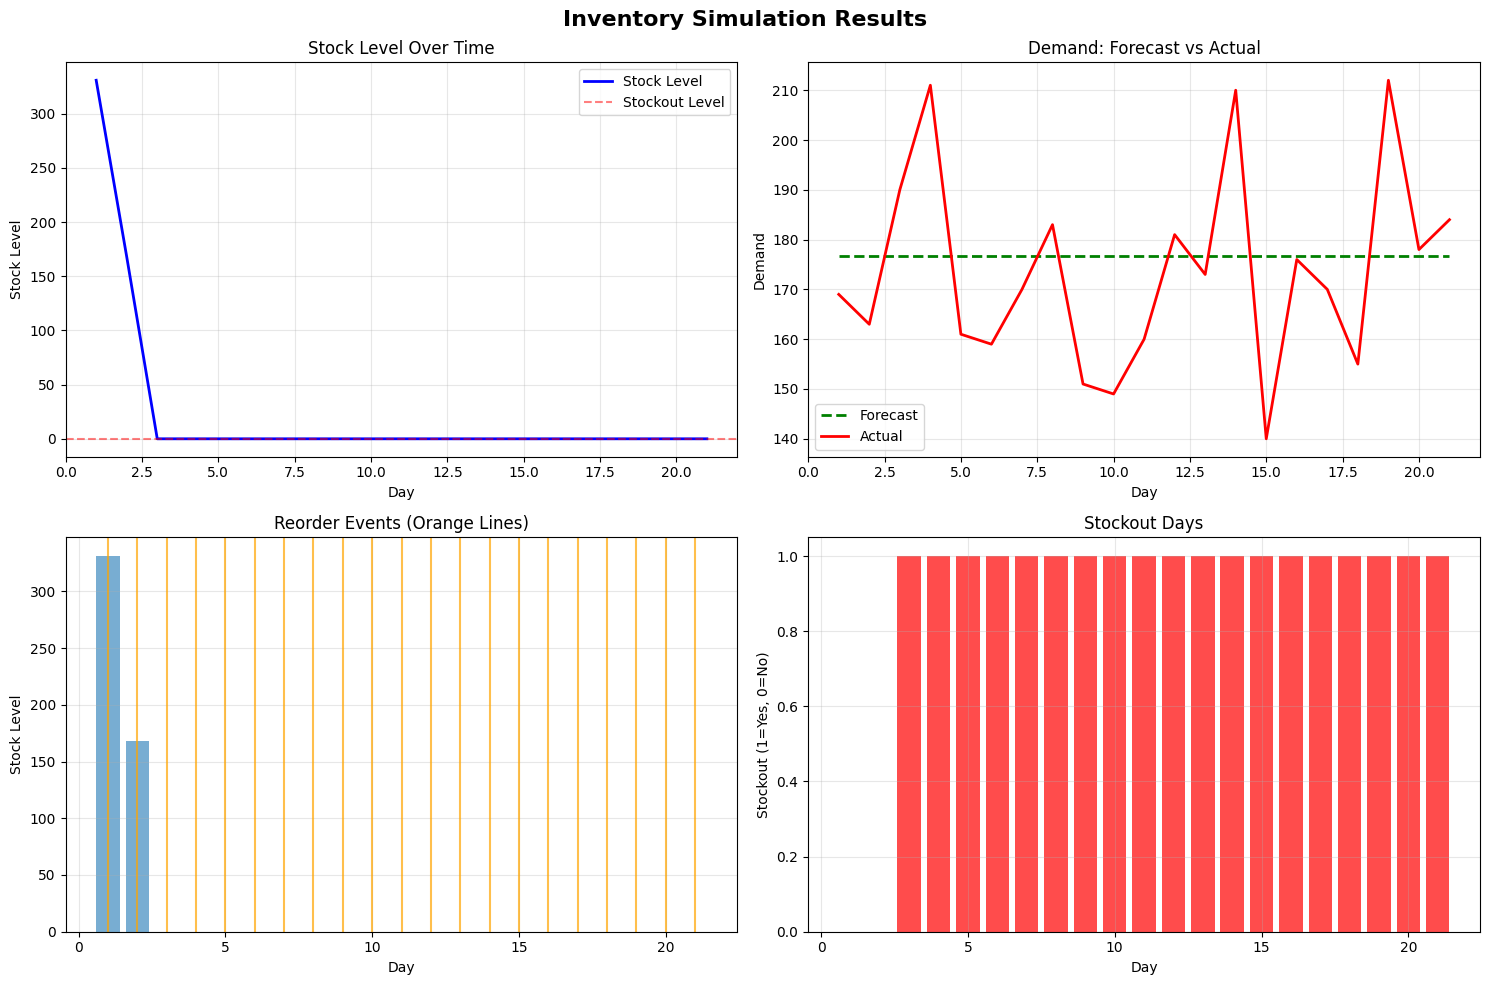

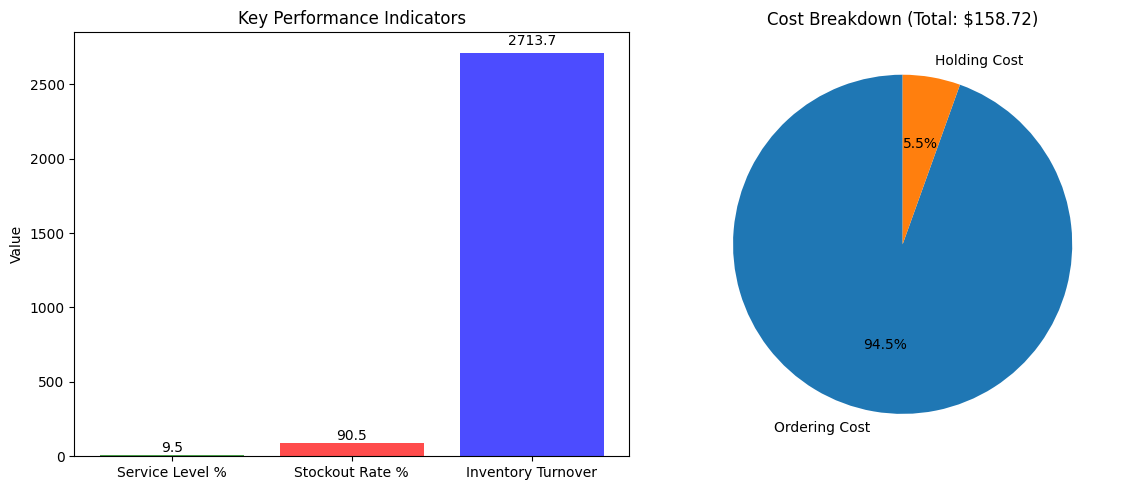


✅ Analysis completed!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class ReplenishmentModel:
    def __init__(self):
        self.sales_data = None
        self.inventory_data = None
        self.supplier_data = None
        self.order_delivery_data = None

    def load_data_from_excel(self, excel_file_path):
        """
        Load data from Excel file with multiple sheets
        Expected sheet names: 'sales', 'inventory', 'suppliers', 'orders'
        """
        try:
            # Load all sheets
            self.sales_data = pd.read_excel(excel_file_path, sheet_name='sales')
            self.inventory_data = pd.read_excel(excel_file_path, sheet_name='inventory')
            self.supplier_data = pd.read_excel(excel_file_path, sheet_name='suppliers')
            self.order_delivery_data = pd.read_excel(excel_file_path, sheet_name='orders')

            print(" Data loaded successfully!")
            self._preprocess_data()

        except Exception as e:
            print(f"Error loading data: {e}")
            print("Make sure your Excel file has sheets named: 'sales', 'inventory', 'suppliers', 'orders'")

    def load_data_from_csv(self, sales_csv, inventory_csv, suppliers_csv, orders_csv):
        """
        Load data from separate CSV files
        """
        try:
            self.sales_data = pd.read_csv(sales_csv)
            self.inventory_data = pd.read_csv(inventory_csv)
            self.supplier_data = pd.read_csv(suppliers_csv)
            self.order_delivery_data = pd.read_csv(orders_csv)

            print(" CSV data loaded successfully!")
            self._preprocess_data()

        except Exception as e:
            print(f" Error loading CSV data: {e}")

    def _preprocess_data(self):
        """
        Clean and preprocess the loaded data
        """
        # Convert date columns
        if 'date' in self.sales_data.columns:
            self.sales_data['date'] = pd.to_datetime(self.sales_data['date'])

        if 'order_date' in self.order_delivery_data.columns:
            self.order_delivery_data['order_date'] = pd.to_datetime(self.order_delivery_data['order_date'])

        if 'delivery_date' in self.order_delivery_data.columns:
            self.order_delivery_data['delivery_date'] = pd.to_datetime(self.order_delivery_data['delivery_date'])

        # Sort sales data by date
        self.sales_data = self.sales_data.sort_values('date')

        print(" Data preprocessing completed!")

    def display_data_info(self):
        """
        Display information about loaded data
        """
        print("\n" + "="*60)
        print(" DATA SUMMARY")
        print("="*60)

        if self.sales_data is not None:
            print(f"Sales Data: {len(self.sales_data)} records")
            print(f"Date range: {self.sales_data['date'].min()} to {self.sales_data['date'].max()}")
            print(f"Unique SKUs: {self.sales_data['sku'].nunique()}")
            print(f"Unique Stores: {self.sales_data['store_id'].nunique()}")

        if self.inventory_data is not None:
            print(f"\nInventory Data: {len(self.inventory_data)} records")

        if self.supplier_data is not None:
            print(f"Supplier Data: {len(self.supplier_data)} records")

        if self.order_delivery_data is not None:
            print(f"Order/Delivery Data: {len(self.order_delivery_data)} records")

    def exponential_smoothing(self, data, alpha=0.3):
        """
        Apply exponential smoothing for demand forecasting
        """
        if len(data) == 0:
            return []

        smoothed = [data[0]]
        for i in range(1, len(data)):
            smoothed.append(alpha * data[i] + (1 - alpha) * smoothed[i-1])

        return smoothed

    def holt_winters_forecast(self, data, alpha=0.3, beta=0.2, gamma=0.1, periods=21):
        """
        Holt-Winters triple exponential smoothing
        """
        if len(data) < 14:  # Need enough data points
            return self.simple_forecast(data, periods)

        n = len(data)

        # Initialize components
        level = data[0]
        trend = (data[1] - data[0])
        seasonal = [0] * min(7, n)  # Weekly seasonality

        forecasts = []

        # Calculate initial seasonal factors
        season_len = min(7, n)
        for i in range(season_len):
            seasonal[i] = data[i] / (level + trend * i)

        # Apply Holt-Winters
        for i in range(1, n):
            prev_level = level
            level = alpha * (data[i] / seasonal[i % season_len]) + (1 - alpha) * (level + trend)
            trend = beta * (level - prev_level) + (1 - beta) * trend
            seasonal[i % season_len] = gamma * (data[i] / level) + (1 - gamma) * seasonal[i % season_len]

        # Generate forecasts
        for i in range(periods):
            forecast = (level + trend * (i + 1)) * seasonal[i % season_len]
            forecasts.append(max(0, forecast))

        return forecasts

    def simple_forecast(self, data, periods=21):
        """
        Simple moving average forecast for cases with insufficient data
        """
        if len(data) == 0:
            return [0] * periods

        avg = np.mean(data[-min(7, len(data)):])  # Use last 7 days or all available
        return [avg] * periods

    def calculate_eoq(self, annual_demand, ordering_cost, holding_cost_rate, unit_cost):
        """
        Calculate Economic Order Quantity
        """
        holding_cost = holding_cost_rate * unit_cost
        if holding_cost <= 0:
            return annual_demand / 12  # Monthly demand as fallback

        eoq = np.sqrt((2 * annual_demand * ordering_cost) / holding_cost)
        return max(1, eoq)

    def calculate_safety_stock(self, demand_std, lead_time, service_level=0.95):
        """
        Calculate safety stock based on service level
        """
        # Z-score for service level
        z_scores = {0.90: 1.28, 0.95: 1.65, 0.99: 2.33}
        z = z_scores.get(service_level, 1.65)

        safety_stock = z * np.sqrt(lead_time) * demand_std
        return max(0, safety_stock)

    def calculate_rop(self, avg_daily_demand, lead_time, safety_stock):
        """
        Calculate Reorder Point
        """
        return (avg_daily_demand * lead_time) + safety_stock

    def analyze_sku(self, sku, store_id=None, service_level=0.95, ordering_cost=50, holding_cost_rate=0.25):
        """
        Comprehensive analysis for a specific SKU
        """
        print(f"\n{'='*60}")
        print(f"ANALYSIS FOR SKU: {sku}")
        if store_id:
            print(f"STORE: {store_id}")
        print(f"{'='*60}")

        # Filter sales data
        if store_id:
            sales = self.sales_data[(self.sales_data['sku'] == sku) &
                                  (self.sales_data['store_id'] == store_id)]
        else:
            sales = self.sales_data[self.sales_data['sku'] == sku]

        if len(sales) == 0:
            print(f" No sales data found for SKU {sku}")
            return None

        # Get inventory information
        if store_id:
            inventory = self.inventory_data[(self.inventory_data['sku'] == sku) &
                                         (self.inventory_data['store_id'] == store_id)]
        else:
            inventory = self.inventory_data[self.inventory_data['sku'] == sku]

        if len(inventory) == 0:
            print(f" No inventory data found for SKU {sku}")
            return None

        inventory_info = inventory.iloc[0]

        # Calculate demand statistics
        daily_demands = sales.groupby('date')['quantity'].sum().reset_index()
        daily_demands = daily_demands.sort_values('date')

        demand_values = daily_demands['quantity'].values
        avg_daily_demand = np.mean(demand_values)
        demand_std = np.std(demand_values)
        annual_demand = avg_daily_demand * 365

        # Calculate model parameters
        eoq = self.calculate_eoq(annual_demand, ordering_cost, holding_cost_rate,
                               inventory_info['unit_cost'])
        safety_stock = self.calculate_safety_stock(demand_std, inventory_info['avg_lead_time'],
                                                 service_level)
        rop = self.calculate_rop(avg_daily_demand, inventory_info['avg_lead_time'], safety_stock)

        # Forecast next 21 days
        forecasts = self.holt_winters_forecast(demand_values, periods=21)

        # Print analysis results
        print(f" Current Stock: {inventory_info['current_stock']}")
        print(f" Unit Cost: ${inventory_info['unit_cost']:.2f}")
        print(f"  Lead Time: {inventory_info['avg_lead_time']} days")
        print(f" Shelf Life: {inventory_info['shelf_life_days']} days")
        print(f"\n DEMAND ANALYSIS:")
        print(f"   Average Daily Demand: {avg_daily_demand:.1f}")
        print(f"   Demand Std Dev: {demand_std:.1f}")
        print(f"   Annual Demand: {annual_demand:.0f}")
        print(f"\n MODEL PARAMETERS:")
        print(f"   EOQ (Optimal Order Qty): {eoq:.0f}")
        print(f"   ROP (Reorder Point): {rop:.0f}")
        print(f"   Safety Stock: {safety_stock:.0f}")
        print(f"   Service Level: {service_level*100}%")

        return {
            'sku': sku,
            'store_id': store_id,
            'inventory_info': inventory_info,
            'demand_stats': {
                'avg_daily_demand': avg_daily_demand,
                'demand_std': demand_std,
                'annual_demand': annual_demand
            },
            'model_params': {
                'eoq': eoq,
                'rop': rop,
                'safety_stock': safety_stock,
                'service_level': service_level
            },
            'forecasts': forecasts,
            'daily_demands': daily_demands
        }

    def run_simulation(self, sku_analysis, simulation_days=21):
        """
        Run inventory simulation for 21 days
        """
        if not sku_analysis:
            return None

        print(f"\n RUNNING {simulation_days}-DAY SIMULATION...")
        print("-" * 50)

        # Initialize simulation
        current_stock = sku_analysis['inventory_info']['current_stock']
        eoq = sku_analysis['model_params']['eoq']
        rop = sku_analysis['model_params']['rop']
        forecasts = sku_analysis['forecasts']
        lead_time = sku_analysis['inventory_info']['avg_lead_time']
        unit_cost = sku_analysis['inventory_info']['unit_cost']

        # Simulation tracking
        simulation_results = []
        pending_orders = []  # [(delivery_day, quantity), ...]
        total_ordering_cost = 0
        total_holding_cost = 0
        stockout_days = 0
        total_orders = 0

        ordering_cost = 50  # Assumed ordering cost
        holding_cost_rate = 0.25 / 365  # Daily holding cost rate

        for day in range(1, simulation_days + 1):
            # Check for incoming deliveries
            pending_orders = [(d, q) for d, q in pending_orders if d != day]
            delivered_today = sum(q for d, q in pending_orders if d == day)
            current_stock += delivered_today

            # Generate actual demand (add some randomness to forecast)
            forecast_demand = forecasts[day-1]
            actual_demand = max(0, np.random.normal(forecast_demand, forecast_demand * 0.1))
            actual_demand = int(actual_demand)

            # Check if reorder needed
            reorder_triggered = current_stock <= rop
            if reorder_triggered and current_stock > 0:
                # Place order
                delivery_day = day + lead_time
                if delivery_day <= simulation_days:
                    pending_orders.append((delivery_day, eoq))
                total_orders += 1
                total_ordering_cost += ordering_cost

            # Fulfill demand
            demand_fulfilled = min(current_stock, actual_demand)
            current_stock = max(0, current_stock - actual_demand)

            # Track stockout
            if current_stock == 0 and actual_demand > demand_fulfilled:
                stockout_days += 1

            # Calculate holding cost
            daily_holding_cost = current_stock * unit_cost * holding_cost_rate
            total_holding_cost += daily_holding_cost

            # Store results
            simulation_results.append({
                'day': day,
                'forecast_demand': forecast_demand,
                'actual_demand': actual_demand,
                'demand_fulfilled': demand_fulfilled,
                'stock_level': current_stock,
                'reorder_triggered': reorder_triggered,
                'delivered_today': delivered_today,
                'stockout': current_stock == 0 and actual_demand > demand_fulfilled
            })

        # Calculate KPIs
        service_level_achieved = ((simulation_days - stockout_days) / simulation_days) * 100
        total_cost = total_ordering_cost + total_holding_cost
        avg_inventory = np.mean([r['stock_level'] for r in simulation_results])

        kpis = {
            'service_level_achieved': service_level_achieved,
            'stockout_days': stockout_days,
            'stockout_rate': (stockout_days / simulation_days) * 100,
            'total_cost': total_cost,
            'total_ordering_cost': total_ordering_cost,
            'total_holding_cost': total_holding_cost,
            'avg_inventory_level': avg_inventory,
            'total_orders': total_orders,
            'inventory_turnover': (sku_analysis['demand_stats']['annual_demand'] * unit_cost) / (avg_inventory * unit_cost) if avg_inventory > 0 else 0
        }

        # Print KPIs
        print(f"\n SIMULATION KPIs:")
        print(f"   Service Level Achieved: {service_level_achieved:.1f}%")
        print(f"   Stockout Rate: {kpis['stockout_rate']:.1f}%")
        print(f"   Total Cost: ${total_cost:.2f}")
        print(f"   Total Orders Placed: {total_orders}")
        print(f"   Average Inventory Level: {avg_inventory:.1f}")
        print(f"   Inventory Turnover: {kpis['inventory_turnover']:.2f}")

        return {
            'simulation_results': simulation_results,
            'kpis': kpis
        }

    def plot_simulation_results(self, simulation_data):
        """
        Create visualizations for simulation results
        """
        if not simulation_data:
            return

        results = simulation_data['simulation_results']
        df = pd.DataFrame(results)

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Inventory Simulation Results', fontsize=16, fontweight='bold')

        # Plot 1: Stock Level Over Time
        axes[0, 0].plot(df['day'], df['stock_level'], 'b-', linewidth=2, label='Stock Level')
        axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Stockout Level')
        axes[0, 0].set_title('Stock Level Over Time')
        axes[0, 0].set_xlabel('Day')
        axes[0, 0].set_ylabel('Stock Level')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Demand vs Forecast
        axes[0, 1].plot(df['day'], df['forecast_demand'], 'g--', linewidth=2, label='Forecast')
        axes[0, 1].plot(df['day'], df['actual_demand'], 'r-', linewidth=2, label='Actual')
        axes[0, 1].set_title('Demand: Forecast vs Actual')
        axes[0, 1].set_xlabel('Day')
        axes[0, 1].set_ylabel('Demand')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: Reorder Events
        reorder_days = df[df['reorder_triggered']]['day']
        axes[1, 0].bar(df['day'], df['stock_level'], alpha=0.6, label='Stock Level')
        for day in reorder_days:
            axes[1, 0].axvline(x=day, color='orange', linestyle='-', alpha=0.7)
        axes[1, 0].set_title('Reorder Events (Orange Lines)')
        axes[1, 0].set_xlabel('Day')
        axes[1, 0].set_ylabel('Stock Level')
        axes[1, 0].grid(True, alpha=0.3)

        # Plot 4: Stockout Analysis
        stockout_indicator = df['stockout'].astype(int)
        axes[1, 1].bar(df['day'], stockout_indicator, color='red', alpha=0.7)
        axes[1, 1].set_title('Stockout Days')
        axes[1, 1].set_xlabel('Day')
        axes[1, 1].set_ylabel('Stockout (1=Yes, 0=No)')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Additional KPI visualization
        kpis = simulation_data['kpis']
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # KPI Bar Chart
        kpi_names = ['Service Level %', 'Stockout Rate %', 'Inventory Turnover']
        kpi_values = [kpis['service_level_achieved'], kpis['stockout_rate'], kpis['inventory_turnover']]

        bars = ax[0].bar(kpi_names, kpi_values, color=['green', 'red', 'blue'], alpha=0.7)
        ax[0].set_title('Key Performance Indicators')
        ax[0].set_ylabel('Value')

        # Add value labels on bars
        for bar, value in zip(bars, kpi_values):
            height = bar.get_height()
            ax[0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{value:.1f}', ha='center', va='bottom')

        # Cost Breakdown
        costs = [kpis['total_ordering_cost'], kpis['total_holding_cost']]
        cost_labels = ['Ordering Cost', 'Holding Cost']

        ax[1].pie(costs, labels=cost_labels, autopct='%1.1f%%', startangle=90)
        ax[1].set_title(f'Cost Breakdown (Total: ${kpis["total_cost"]:.2f})')

        plt.tight_layout()
        plt.show()

# Example usage and data templates
def create_sample_data_templates():
    """
    Create sample Excel templates for user data
    """
    print("Creating sample data templates...")

    # Sample sales data
    sales_data = {
        'sku': ['SKU001', 'SKU001', 'SKU001', 'SKU002', 'SKU002'],
        'quantity': [150, 200, 180, 75, 90],
        'date': ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-01', '2024-01-02'],
        'store_id': ['ST001', 'ST001', 'ST001', 'ST001', 'ST001']
    }

    # Sample inventory data
    inventory_data = {
        'sku': ['SKU001', 'SKU002'],
        'store_id': ['ST001', 'ST001'],
        'current_stock': [500, 300],
        'unit_cost': [25.50, 18.75],
        'avg_lead_time': [7, 5],
        'shelf_life_days': [30, 45]
    }

    # Sample supplier data
    supplier_data = {
        'supplier_id': ['SUP001', 'SUP002'],
        'service_level': [0.92, 0.88],
        'delay_rate': [0.08, 0.12]
    }

    # Sample orders data
    orders_data = {
        'sku': ['SKU001', 'SKU002'],
        'order_date': ['2024-01-01', '2024-01-02'],
        'delivery_date': ['2024-01-08', '2024-01-07'],
        'supplier_id': ['SUP001', 'SUP002']
    }

    # Create Excel file with multiple sheets
    with pd.ExcelWriter('sample_inventory_data.xlsx') as writer:
        pd.DataFrame(sales_data).to_excel(writer, sheet_name='sales', index=False)
        pd.DataFrame(inventory_data).to_excel(writer, sheet_name='inventory', index=False)
        pd.DataFrame(supplier_data).to_excel(writer, sheet_name='suppliers', index=False)
        pd.DataFrame(orders_data).to_excel(writer, sheet_name='orders', index=False)

    print(" Sample data template created: 'sample_inventory_data.xlsx'")
    print("You can use this as a reference for your data structure.")

# Main execution function
def main():
    """
    Main function to run the replenishment analysis
    """
    print(" INVENTORY REPLENISHMENT MODEL")
    print("=" * 50)

    # Initialize model
    model = ReplenishmentModel()

    # Create sample template (optional)
    create_sample_data_templates()

    # Load your data (replace with your actual file path)
    print("\n Loading your data")
    print("Replace 'your_data.xlsx' with your actual file path")

    # Uncomment and modify one of these lines to load your data:
    # model.load_data_from_excel('your_data.xlsx')  # For Excel file
    # model.load_data_from_csv('sales.csv', 'inventory.csv', 'suppliers.csv', 'orders.csv')  # For CSV files

    # For demonstration, load sample data
    model.load_data_from_excel('sample_inventory_data.xlsx')

    # Display data information
    model.display_data_info()

    # Analyze specific SKU
    sku_to_analyze = 'SKU001'  # Change this to your SKU
    store_to_analyze = 'ST001'  # Change this to your store ID

    analysis = model.analyze_sku(sku_to_analyze, store_to_analyze)

    if analysis:
        # Run simulation
        simulation = model.run_simulation(analysis)

        if simulation:
            # Plot results
            model.plot_simulation_results(simulation)

    print("\n Analysis completed!")

if __name__ == "__main__":
    main()